In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys
import math
import json
import re

hf = "/home"
sys.path.append(hf+"/will/projects/legoproj")
sys.path.append(hf+"/will/projects/training/dataprep")

import feature_utils as fu
from cvscripts import cv_utils as cvu

%matplotlib inline

import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
session = Session(config=config)

import keras
from keras.models import load_model


def getObjFromHue(hue,dset):
    hue = int(round(hue/5))
    name = dset["ids"][str(hue)]
    return name


def getObjectsData(dset):
    
    objsdata = {}
    for entry in dset["ids"]:

        if entry == "0":
            continue

        name = dset["ids"][entry]
        objentry = dset["objects"][name]

        #print(objentry)

        l2w = fu.matrix_from_string(objentry["modelmat"])
        w2l = np.linalg.inv(l2w)

        bbl = np.array(objentry["bbl"])
        bbh = np.array(objentry["bbh"])

        dims = bbh - bbl

        info = {}
        info["w2l"] = w2l
        info["lows"] = bbl

        info["dims"] = dims
        info["name"] = dset["ids"][entry]

        objsdata[name] = info
        
    return objsdata

/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [2]:
x = np.arange(-1.0,1.25,.25)
y = np.arange(-1.0,1.25,.25)

r,c = np.meshgrid(x,y)
inds = np.stack((r,c),axis=-1).astype(np.float32)


z = np.zeros((9,9,1))
w = np.ones((9,9,1))
#print(inds)
#print(w)

studs = np.concatenate((inds,z,w),axis=-1)
studs = np.reshape(studs,(-1,4))
#print(studs)

[[-1.        -1.         0.       ]
 [ 1.        -1.         0.       ]
 [-1.         1.         0.       ]
 [ 1.         1.         0.       ]
 [ 0.        -1.3810458  0.       ]
 [ 0.         1.3810458  0.       ]
 [-1.8885571  0.         0.       ]
 [ 1.8885571  0.         0.       ]
 [ 0.         0.         0.       ]]
[[321. 241.]
 [316. 108.]
 [197. 260.]
 [178. 117.]
 [342. 175.]
 [160. 195.]
 [266. 304.]
 [244.  41.]
 [256. 184.]]
[[382.72003   0.      256.     ]
 [  0.      382.72003 256.     ]
 [  0.        0.        1.     ]]


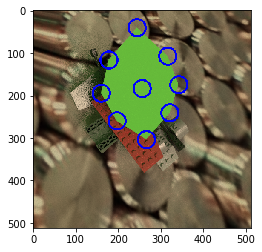

In [3]:
datapath = "/home/will/projects/legoproj/data/kpts_dset_5/"
data = fu.dictFromJson(datapath + "dset.json")
i = 65
tag = "{:0>4}".format(i)
maskpath = datapath + "{}_masks.png".format(tag)

mask = cv2.imread(maskpath)
masks = cvu.separate(mask)

for hue in masks:
    objname = getObjFromHue(hue,data)
    if objname:
        objclass = objname.split(".")[0]
        if objclass == "WingL":
            wing = objname
            break
            

#studs = fu.get_object_studs(objclass)

'''
#for stud in studs:
#    stud.append(1.0)
    
incs = np.array([0.0,0.0,-8.0,0.0],dtype=np.float32)
    
projmat = fu.matrix_from_string(data["projection"])
modelmat = np.eye(4,dtype=np.float32)  #fu.matrix_from_string(data["objects"][objname]["modelmat"])
viewmat =  np.eye(4,dtype=np.float32) #fu.matrix_from_string(data["viewmats"][i])
#print(projmat)
#print(studs)
#print(studs)
studs = studs[::5]
screenverts = fu.verts_to_screen(modelmat, viewmat, projmat, studs + incs , filter=False)
screenverts[:,0:2] = fu.toNDC(screenverts[:,0:2], (512,512))
#print(screenverts)

overts = np.array(studs, dtype=np.float32)[:,0:3]
#overts[:,2] = 0.0
sverts = np.array(screenverts, dtype=np.float32)[:,0:2]#[:,1::-1]
print(overts)
print(sverts)
'''
overts, sverts = fu.getCalibCorrs()
calibimg = cv2.imread(hf+"/will/projects/legoproj/cvscripts/calib_data/calib.png")

for vert in sverts:
    cv2.circle(calibimg, (int(vert[0]), int(vert[1])), 20, (0, 0, 255), 3)

print(overts)
print(sverts)
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([overts.astype('float32')], [sverts.astype('float32')], (512,512), None, None)
mtx = np.load(hf+"/will/projects/legoproj/cvscripts/calib_data/" + "camins.npy")
print(mtx)

plt.imshow(calibimg)
plt.show()
#mtx =  np.array([[576.25736016,  0.,  248.52187883],[  0., 574.53464108, 245.49564339],[  0., 0., 1.  ]])
 
#[[576.25736016   0.         248.52187883]
# [  0.         574.53464108 245.49564339]
# [  0.           0.           1.        ]]

In [4]:
model = load_model("/home/will/projects/legoproj/nets/tstgeom_poleeng_bayes_fr.h5",compile=False)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





In [160]:
i = 3
tag = "{:0>4}".format(i)

img = cv2.imread(datapath + "{}_a.png".format(tag),0)        
img = cv2.resize(img,(256,256),interpolation=cv2.INTER_LINEAR)
geomraw = cv2.imread(datapath + "geom/{}_geom.png".format(tag))

pred = model.predict( np.reshape(img, (1,256,256,1)).astype('float32')/255.0 )
pred =  (255.0 * np.reshape((1.0+pred)/2.0, (256,256,4)))

geom_pred = pred[:,:,0:3].astype(np.uint8)
confidence = (255 - np.reshape( pred[:,:,3:], (256,256) ))

confidence[confidence > 240] = 255
confidence[confidence < 100] = 1
confidence = confidence.astype(np.uint8)


names = []

maskpath = datapath + "{}_masks.png".format(tag)

mask = cv2.imread(maskpath)
masks = cvu.separate(mask)

for hue in masks:
    objname = getObjFromHue(hue,data)
    #print(objname)
    if objname:
        objclass = objname.split(".")[0]
        print(objname)
        if objclass and objname == "Engine.003":# or objclass == "Pole"):
            names.append(tuple([objname,hue]))

Engine.003
Pole.005
Engine.001
Pole.004
WingR.001
WingL.001
Cockpit.001
Pole.001


Engine.003


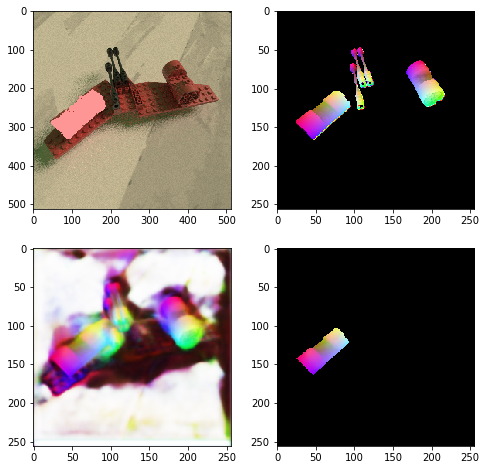

In [161]:
rows = np.arange(256)
cols = np.arange(256)

r,c = np.meshgrid(rows,cols)
inds = np.stack((r,c),axis=-1).astype(np.uint8)

inds = np.dstack(np.meshgrid(np.arange(256), np.arange(256)))

objsdata = getObjectsData(data)
kernel = np.ones((3,3),np.uint8)

    
for obj in names:
    
    name, hue = obj[0], obj[1]

    
    dims = objsdata[name]["dims"]
    bbl = objsdata[name]["lows"]
    
    objmask = masks[hue]
    
    print(name)
    
    objmask = cv2.resize(objmask, (256,256), cv2.INTER_LINEAR)
    objmask = cv2.erode(objmask,kernel,iterations = 2)

    geom_pred = cv2.resize(geom_pred, (256,256), cv2.INTER_LINEAR)
    confidence = cv2.resize(confidence, (256,256), cv2.INTER_LINEAR)
    
    region = cv2.bitwise_and(geom_pred,geom_pred,mask=objmask)
    #region = cv2.bitwise_and(geomraw,geomraw,mask=objmask)

    conf = cv2.bitwise_and(confidence,confidence,mask=objmask)
    
    thresh = conf > 250
    coords = (bbl[2::-1] + dims[2::-1] * (region[thresh]/255))
    
    locs = 2*inds[thresh]

    break
    
    
#name="Pole.001"

#final = []
#for x,y,z in np.ndindex((3,3,3)):
    #final.append([x,y,z,1.0])

    
temp = np.ones((coords.shape[0],4),dtype=np.float32)
temp[:,2::-1] = coords
temp[:,3] = 1.0
coords = temp

projmat = fu.matrix_from_string(data["projection"])
modelmat = fu.matrix_from_string(data["objects"][name]["modelmat"])
viewmat =  fu.matrix_from_string(data["viewmats"][i])

screenverts = fu.verts_to_screen(modelmat, viewmat, projmat, coords , filter=False)
screenverts[:,0:2] = fu.toNDC(screenverts[:,0:2], (512,512))

tst = cv2.imread(datapath + "{}_a.png".format(tag))        

for vert in screenverts:
    cv2.circle(tst, (int(vert[0]), int(vert[1])), 5, (255, 150, 150), 1)

coords = coords[0:-1:10,0:3]# engverts[:,0:3]
locs = locs[0:-1:10,0:2]

rows = 2
cols = 2
fig=plt.figure(figsize=(8, 8))
    
fig.add_subplot(rows, cols, 1)
plt.imshow(tst)

fig.add_subplot(rows, cols, 2)
plt.imshow(geomraw)

fig.add_subplot(rows, cols, 3)
plt.imshow(geom_pred)

fig.add_subplot(rows, cols, 4)
plt.imshow(region)


plt.show()


In [162]:
#ret, rvec, tvec,inliers = cv2.solvePnPRansac(coords.astype(np.float32), locs.astype(np.float32), mtx,None,flags=cv2.SOLVEPNP_EPNP,reprojectionError=3,iterationsCount=100)
print(coords.shape)
ret, rvec, tvec, inliers = cv2.solvePnPRansac(coords.astype(np.float32), locs.astype(np.float32), mtx, None, flags=(cv2.SOLVEPNP_ITERATIVE),reprojectionError=2,iterationsCount=100)
#ret, rvec, tvec = cv2.solvePnP(coords.astype(np.float32), locs.astype(np.float32), mtx,None,flags=cv2.SOLVEPNP_EPNP)


(179, 3)


[[[118 265]]

 [[158 305]]

 [[170 223]]

 [[ 86 228]]]
True
(158, 305)
(170, 223)
(86, 228)


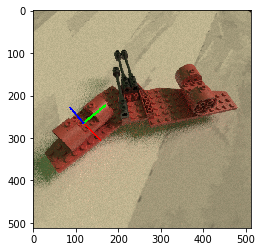

'\nrvec = r[1]\ntvec = r[2]\ntvec\n'

In [163]:
(pt, jac) = cv2.projectPoints(np.array([(0,0.0,0.0),(1.0, 0.0, 0.0),(0.0, 1.0, 0.0),(0.0, 0.0, 1.0)]), rvec, tvec, mtx, dist)
pt = pt.astype(int)
print(pt)
img3 = cv2.imread(datapath + "{}_a.png".format(tag))        

print(ret)
#print("in")
#print(inliers)


lines = [(255,0,0), (0,255,0), (0,0,255)]


i = 0
for point in pt[1:4]:
    o = pt[0][0]
    print(tuple(point[0]))
    if o[0] > 512:
        continue
    cv2.line(img3, tuple(o), tuple(point[0]), lines[i], 3)
    i+=1
    
plt.imshow(img3)
plt.show()

'''
rvec = r[1]
tvec = r[2]
tvec
'''